Veri seti oluşturuluyor...
Veri seti hazırlandı.
Model için öznitelikler (features) oluşturuldu.
243 gün ile model eğitilecek...
Model eğitildi. (Linear Regression)
Tüm periyot için 'olması gereken' tahminler yapıldı.
Sonuçlar çiziliyor...


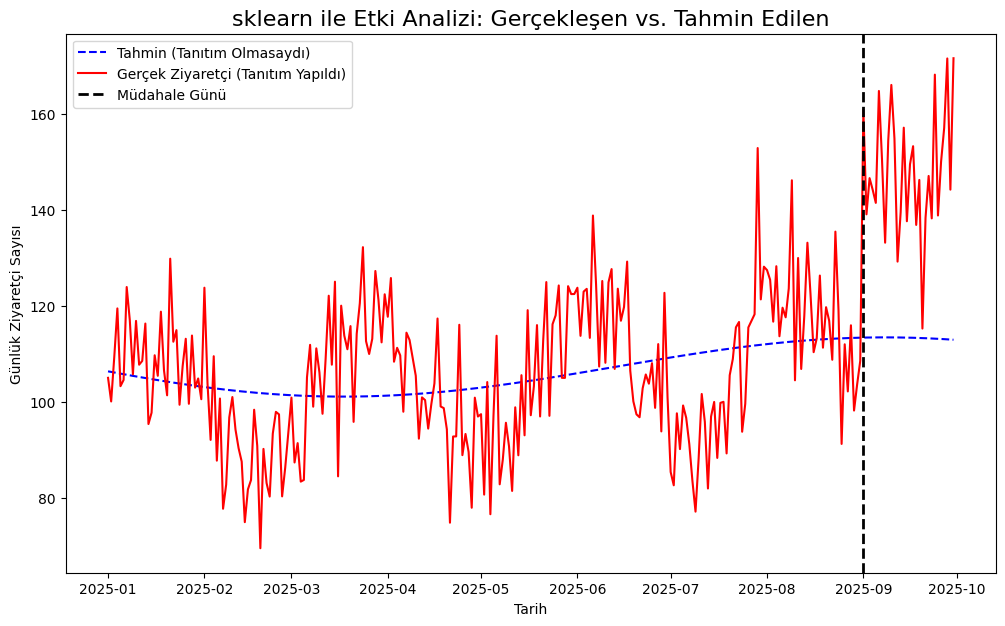


--- ETKİ ANALİZİ RAPORU (Eylül Ayı) ---
Twitter tanıtımı, Eylül ayı boyunca toplamda yaklaşık 1000 ekstra ziyaretçi getirdi.
Bu, günlük ortalama 34.5 ekstra ziyaretçi anlamına geliyor.


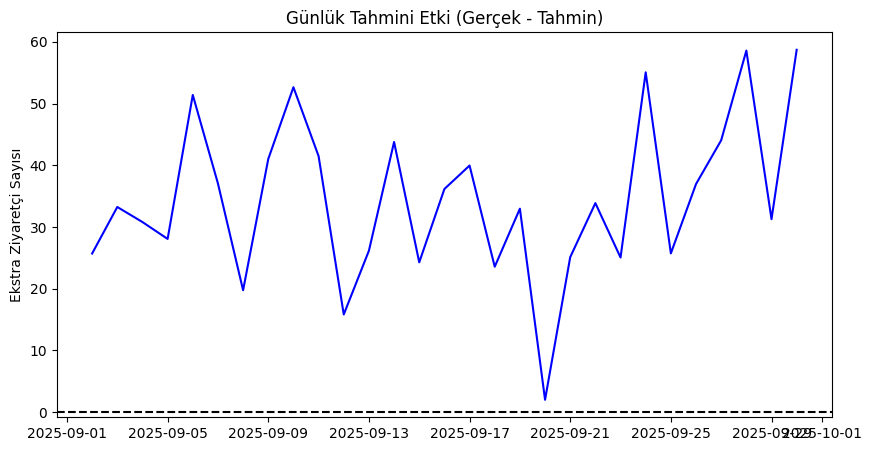

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------------------------
# 1. VERİ SETİNİ OLUŞTURMA 
# -----------------------------------------------
print("Veri seti oluşturuluyor...")
dates = pd.date_range(start='2025-01-01', end='2025-09-30', freq='D')
pre_period_length = len(pd.date_range(start='2025-01-01', end='2025-08-31'))
post_period_length = len(pd.date_range(start='2025-09-01', end='2025-09-30'))
total_length = pre_period_length + post_period_length

np.random.seed(42)
noise = np.random.normal(loc=0, scale=10, size=total_length)
trend_effect = np.linspace(start=0, stop=10, num=total_length)
seasonality_effect = 15 * np.sin(np.linspace(0, 8 * np.pi, total_length))
y_pre = 100 + trend_effect[:pre_period_length] + seasonality_effect[:pre_period_length] + noise[:pre_period_length]
twitter_effect = 50
y_post = 100 + trend_effect[pre_period_length:] + seasonality_effect[pre_period_length:] + noise[pre_period_length:] + twitter_effect
y = np.concatenate([y_pre, y_post])

data = pd.DataFrame({'tarih': dates, 'ziyaretci': y})
data = data.set_index('tarih')
print("Veri seti hazırlandı.")

# -----------------------------------------------
# 2. MODEL İÇİN "ÖZNİTELİK" (FEATURE) OLUŞTURMA
# -----------------------------------------------

df_model = data.reset_index().rename(columns={'tarih': 'ds'})

df_model['time_step'] = np.arange(len(df_model))

df_model['day_of_year'] = df_model['ds'].dt.dayofyear
df_model['sin_season'] = np.sin(2 * np.pi * df_model['day_of_year'] / 365.25)
df_model['cos_season'] = np.cos(2 * np.pi * df_model['day_of_year'] / 365.25)

print("Model için öznitelikler (features) oluşturuldu.")

# -----------------------------------------------
# 3. VERİYİ EĞİTİM VE TEST OLARAK AYIRMA
# -----------------------------------------------

pre_data = df_model[df_model['ds'] <= '2025-08-31']
post_data = df_model[df_model['ds'] > '2025-08-31']

X_train = pre_data[['time_step', 'sin_season', 'cos_season']]
y_train = pre_data['ziyaretci']

X_all = df_model[['time_step', 'sin_season', 'cos_season']]

print(f"{len(X_train)} gün ile model eğitilecek...")

# -----------------------------------------------
# 4. MODELİ EĞİTME (SADECE pre_data İLE)
# -----------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train) 
print("Model eğitildi. (Linear Regression)")

# -----------------------------------------------
# 5. TAHMİN (FORECAST) YAPTIRMA
# -----------------------------------------------

df_model['tahmin_yhat'] = model.predict(X_all)

print("Tüm periyot için 'olması gereken' tahminler yapıldı.")

# -----------------------------------------------
# 6. GÖRSELLEŞTİRME VE YORUMLAMA
# -----------------------------------------------
print("Sonuçlar çiziliyor...")

plt.figure(figsize=(12, 7))

# 1. Tahmin (Tanıtım Olmasaydı)

plt.plot(df_model['ds'], df_model['tahmin_yhat'], 'b--', label='Tahmin (Tanıtım Olmasaydı)')

# 2. Gerçek (Tanıtım Yapıldı)
plt.plot(df_model['ds'], df_model['ziyaretci'], 'r-', label='Gerçek Ziyaretçi (Tanıtım Yapıldı)')

plt.axvline(pd.to_datetime('2025-09-01'), color='k', linestyle='--', lw=2, label='Müdahale Günü')
plt.legend()
plt.title('sklearn ile Etki Analizi: Gerçekleşen vs. Tahmin Edilen', fontsize=16)
plt.xlabel('Tarih')
plt.ylabel('Günlük Ziyaretçi Sayısı')
plt.show()

# -----------------------------------------------
# 7. ETKİYİ SAYISALLAŞTIRMA
# -----------------------------------------------

results_post = df_model[df_model['ds'] > '2025-09-01'].copy()

results_post['etki'] = results_post['ziyaretci'] - results_post['tahmin_yhat']

print("\n--- ETKİ ANALİZİ RAPORU (Eylül Ayı) ---")
toplam_etki = results_post['etki'].sum()
ortalama_etki = results_post['etki'].mean()

print(f"Twitter tanıtımı, Eylül ayı boyunca toplamda yaklaşık {toplam_etki:.0f} ekstra ziyaretçi getirdi.")
print(f"Bu, günlük ortalama {ortalama_etki:.1f} ekstra ziyaretçi anlamına geliyor.")

plt.figure(figsize=(10, 5))
plt.plot(results_post['ds'], results_post['etki'], 'b-')
plt.axhline(0, color='k', linestyle='--')
plt.title('Günlük Tahmini Etki (Gerçek - Tahmin)')
plt.ylabel('Ekstra Ziyaretçi Sayısı')
plt.show()

#